In [ ]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns
# plt.style.use('seaborn-white')
sns.set_context('talk')
sns.set_style('whitegrid')
sns.despine(left=True)

In [25]:
directory = '../../data/raw/logs/20200602/throughput/'

In [30]:
def get_log_files(pattern):
    result = []
    for filename in os.listdir(directory):
        res = re.search(pattern, filename)
        if res:
            data_size = res.group(1)
            segment_count = res.group(2)
            rate_limit = res.group(3)
            if data_size:
                result.append((data_size, segment_count, rate_limit, filename))
    return result

In [31]:
def get_kafka_files(pattern):
    result = []
    for filename in os.listdir(directory):
        res = re.search(pattern, filename)
        if res:
            data_size = res.group(1)
            rate_limit = res.group(2)
            if data_size:
                result.append((data_size, rate_limit, filename))
    return result

In [32]:
def get_consumer_files(pattern):
    result = []
    for filename in os.listdir(directory):
        res = re.search(pattern, filename)
        if res:
            data_size = res.group(1)
            if data_size:
                result.append((data_size, filename))
    return result

In [33]:
def get_kafka_latency_timeline_files():
    return get_kafka_files("kafka_producer_(\d+)_(\d+)_latency_timeline.csv")
def get_kafka_latency_histogram_files():
    return get_kafka_files("kafka_producer_(\d+)_(\d+)_latency_histogram.csv")
def get_kafka_producer_throughput_files():
    return get_kafka_files("kafka_producer_(\d+)_(\d+)_throughput.csv")
def get_kafka_consumer_throughput_files():
    return get_kafka_files("kafka_consumer_(\d+)_(\d+)_throughput.csv")

In [34]:
def get_rembrandt_latency_timeline_files():
    return get_log_files("rembrandt_producer_(\d+)_(\d+)_(\d+)_latency_timeline.csv")
def get_rembrandt_latency_histogram_files():
    return get_log_files("rembrandt_producer_(\d+)_(\d+)_(\d+)_latency_histogram.csv")
def get_rembrandt_producer_throughput_files():
    return get_log_files("rembrandt_producer_(\d+)_(\d+)_(\d+)_throughput.csv")
def get_rembrandt_consumer_throughput_files():
    return get_consumer_files("rembrandt_consumer_(\d+)_throughput.csv")

In [35]:
def create_kafka_producer_dataframe(log_files, skiprows=0):
    joined_df = pd.DataFrame()
    for data_size, rate_limit, filename in log_files:
        df  = pd.read_csv(directory + "/" + filename, sep='\t', skiprows=skiprows)
        df.reset_index(inplace=True)
        df["Message Size"] = int(data_size)
        df["Rate Limit in MB/s"] = int(rate_limit) // (1000 * 1000)
        joined_df = pd.concat([joined_df, df])
    return joined_df

In [37]:
def create_kafka_consumer_dataframe(log_files, skiprows=0):
    joined_df = pd.DataFrame()
    for data_size, rate_limit, filename in log_files:
        df  = pd.read_csv(directory + "/" + filename, sep='\t', skiprows=skiprows)
        df.reset_index(inplace=True)
        df["Message Size"] = int(data_size)
        joined_df = pd.concat([joined_df, df])
    return joined_df

In [38]:
def create_rembrandt_dataframe(log_files, skiprows=0):
    joined_df = pd.DataFrame()
    for data_size, segment_count, rate_limit, filename in log_files:
        df  = pd.read_csv(directory + "/" + filename, sep='\t', skiprows=skiprows)
        df.reset_index(inplace=True)
        df["Message Size"] = int(data_size)
        df["# of Segments"] = int(segment_count)
        df["Rate Limit in MB/s"] = int(rate_limit) // (1000 * 1000)
        joined_df = pd.concat([joined_df, df])
    return joined_df

In [39]:
def create_rembrandt_consumer_dataframe(log_files, skiprows=0):
    joined_df = pd.DataFrame()
    for data_size, filename in log_files:
        df  = pd.read_csv(directory + "/" + filename, sep='\t', skiprows=skiprows)
        df.reset_index(inplace=True)
        df["Message Size"] = int(data_size)
        joined_df = pd.concat([joined_df, df])
    return joined_df

In [40]:
def plot_histogram(dataframe):
#     fig_dims = (18, 12)
    fig, ax = plt.subplots()
#     sns.set(font_scale=2)
    sns.set_context('poster')
    sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
    sns.despine(left=True)
    g = sns.lineplot(x="Message Size", y="Throughput in MB/s", data=dataframe, ax=ax,ci="sd")
    g.set_ylabel("Throughput (MB/s)")
    ax.set_xscale('log')
    g.set_xticks([8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608])
    g.set_xticklabels(['8K','16K','32K','64K','128K','256K','512K','1M', '2M', '4M', '8M'])
    plt.xticks(fontsize=20, rotation=45)
    plt.yticks(fontsize=20)

In [19]:
kafka_producer_log_files = get_kafka_producer_throughput_files()
kafka_producer_df = create_kafka_producer_dataframe(kafka_producer_log_files)
kafka_producer_df.head()

,index,Number of Messages,Throughput in MB/s,Message Size in Bytes,Rate Limit in MB/s
0,0,3243,212.533,65536,1000
1,1,3315,217.252,65536,1000
2,2,3223,211.223,65536,1000
3,3,2829,185.401,65536,1000
4,4,2859,187.367,65536,1000


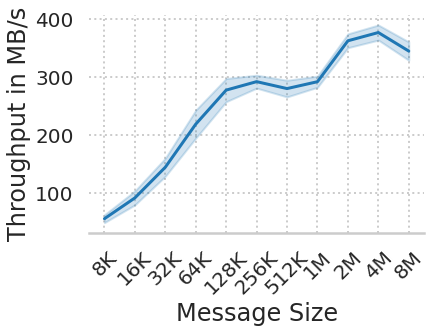

In [20]:
plot_histogram(kafka_producer_df)

In [21]:
kafka_consumer_log_files = get_kafka_consumer_throughput_files()
kafka_consumer_df = create_kafka_consumer_dataframe(kafka_consumer_log_files)
kafka_consumer_df.head()

,index,Number of Messages,Throughput in MB/s,Message Size in Bytes
0,0,2320,38.011,16384
1,1,2431,39.830,16384
2,2,3511,57.524,16384
3,3,3403,55.755,16384
4,4,3436,56.295,16384


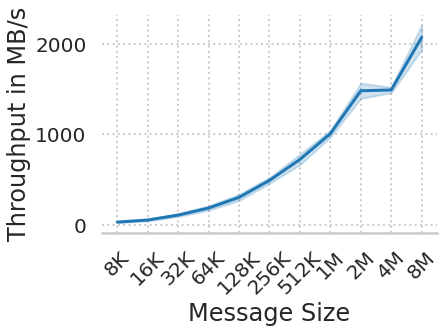

In [22]:
plot_histogram(kafka_consumer_df)

In [13]:
rembrandt_producer_log_files = get_rembrandt_producer_throughput_files()
rembrandt_producer_df = create_rembrandt_dataframe(rembrandt_producer_log_files)
rembrandt_producer_df.head()

,index,Number of Messages,Throughput in MB/s,Message Size in Bytes,# of Segments,Rate Limit in MB/s
0,0,68776,563.413,8192,1,20000
1,1,68764,563.315,8192,1,20000
2,2,68752,563.216,8192,1,20000
3,3,70163,574.775,8192,1,20000
4,4,70715,579.297,8192,1,20000


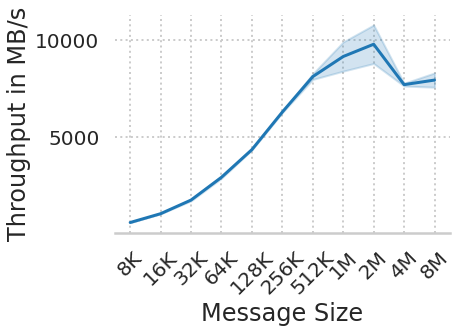

In [24]:
plot_histogram(rembrandt_producer_df)

In [15]:
rembrandt_consumer_log_files = get_rembrandt_consumer_throughput_files()
rembrandt_consumer_df = create_rembrandt_consumer_dataframe(rembrandt_consumer_log_files)
rembrandt_consumer_df.head()

,index,Number of Messages,Throughput in MB/s,Message Size in Bytes
0,0,2794,11718.885,4194304
1,1,2792,11710.497,4194304
2,2,2792,11710.497,4194304
3,3,2793,11714.691,4194304
4,4,2792,11710.497,4194304


In [16]:
rembrandt_consumer_df.groupby("Message Size in Bytes").mean()

,index,Number of Messages,Throughput in MB/s
Message Size in Bytes,,,
8192,24.0,212130.428571,1737.772490
16384,14.0,176731.551724,2895.569759
32768,9.5,127758.950000,4186.405300
65536,6.5,89436.142857,5861.287143
131072,6.0,47815.000000,6267.207692
262144,4.5,31220.900000,8184.371700
524288,3.5,18603.375000,9753.526125
1048576,3.0,10285.714286,10785.353143
2097152,3.0,5430.857143,11389.333143


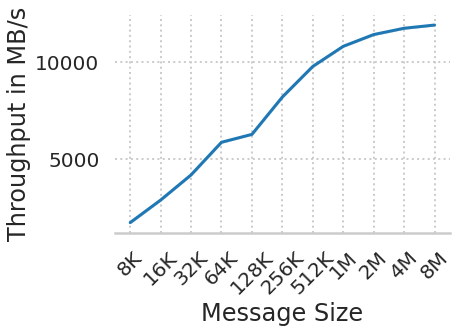

In [39]:
plot_histogram(rembrandt_consumer_df)

In [41]:
def plot_comp_histogram(kafka_df, rembrandt_df, filename):
    kafka_df["Broker"] = "Kafka"
    rembrandt_df["Broker"] = "Prototype"
    df = pd.concat([kafka_df, rembrandt_df])
    fig, ax = plt.subplots()
    sns.set_context('talk')
    sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
    sns.despine(left=True)
    g = sns.lineplot(x="Message Size in Bytes", y="Throughput in MB/s", hue="Broker", data=df, ax=ax,ci="sd")
    g.set_xlabel("Message Size")
    g.set_ylabel("Avg. Throughput (MB/s)")
    ax.set_xscale('log')
    g.set_xticks([8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608])
    g.set_xticklabels(['8K','16K','32K','64K','128K','256K','512K','1M', '2M', '4M', '8M'])
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:])
    plt.xticks(rotation=45)
#     plt.yticks(fontsize=20)
    fig.savefig(filename, bbox_inches="tight", dpi=600)

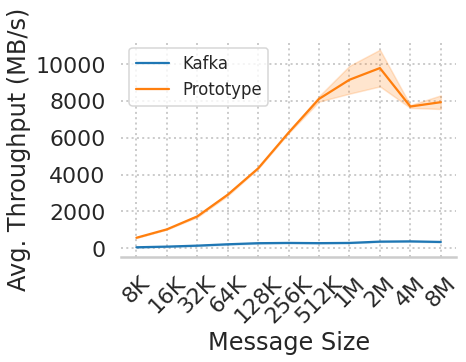

In [42]:
plot_comp_histogram(kafka_producer_df, rembrandt_producer_df, "producer_throughput.png")

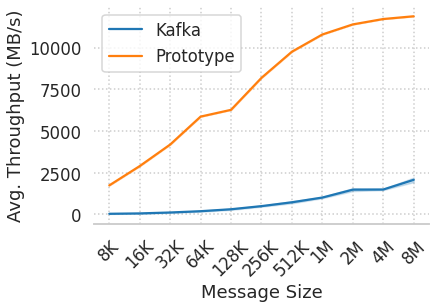

In [43]:
plot_comp_histogram(kafka_consumer_df, rembrandt_consumer_df, "consumer_throughput.png")

# Sustainable Throughput & Latency

In [51]:
directory = '../../data/raw/logs/20200602/latencies/'

In [95]:
kafka_timeline_df = create_kafka_producer_dataframe(get_kafka_latency_timeline_files(), skiprows=2)
kafka_timeline_df.head()

,index,Avg. Latency in us,Min. Latency in us,Max. Latency in us,Message Size in Bytes,Rate Limit in MB/s
0,0,1250.5,621,1757,131072,250
1,1,2786.3,442,6270,131072,250
2,2,6365.5,5880,6900,131072,250
3,3,7105.9,6407,7769,131072,250
4,4,8030.8,7403,8645,131072,250


In [98]:
kafka_timeline_df.groupby("Rate Limit in MB/s")["Avg. Latency in us"].mean()

Rate Limit in MB/s
200    148282.563024
210    221173.247444
220    154132.488155
230     59464.123575
240    474425.943185
250    452299.212058
260    254053.965547
Name: Avg. Latency in us, dtype: float64

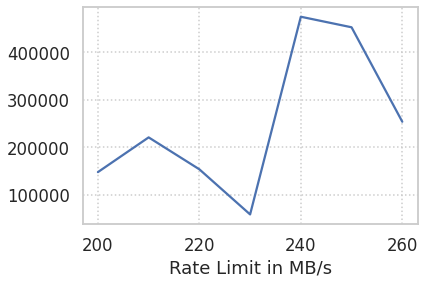

In [99]:
kafka_timeline_df.groupby("Rate Limit in MB/s")["Avg. Latency in us"].mean().plot()

In [55]:
timeline_df = create_rembrandt_dataframe(get_rembrandt_latency_timeline_files(), skiprows=2)
timeline_df.head()

,index,Avg. Latency in us,Min. Latency in us,Max. Latency in us,Message Size in Bytes,# of Segments,Rate Limit in MB/s
0,0,499.2,52,1055,262144,1,6100
1,1,1164.9,950,1331,262144,1,6100
2,2,1401.2,1210,1591,262144,1,6100
3,3,1702.3,1506,1855,262144,1,6100
4,4,2115.3,1842,2314,262144,1,6100


In [ ]:
timeline_df[timeline_df["Message Size in Bytes"] = 262144]

In [63]:
timeline_df[timeline_df["Message Size in Bytes"] == 262144].groupby("Rate Limit in MB/s")["Avg. Latency in us"].mean()

Rate Limit in MB/s
5200       102.535612
5300       126.973329
5400       119.736100
5500       146.360757
5600       269.487641
5700       591.775008
5800       484.807629
5900      1929.807934
6000    121280.839609
6100    275150.718889
Name: Avg. Latency in us, dtype: float64

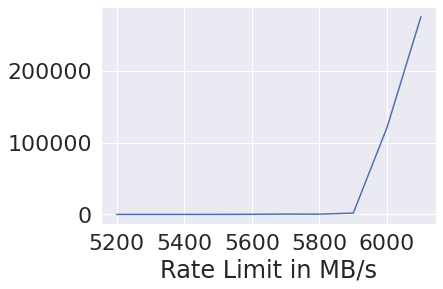

In [66]:
timeline_df[timeline_df["Message Size in Bytes"] == 262144].groupby("Rate Limit in MB/s")["Avg. Latency in us"].mean().plot()

In [60]:
def plot_timeseries(dataframe, column):
    fig_dims = (18, 12)
    fig, ax = plt.subplots(figsize=fig_dims)
    sns.set(font_scale=2)
    df = dataframe.pivot(index='index', columns='Rate Limit in MB/s', values=column)
    df.plot(ax=ax)
#     sns.lineplot(x="index", y=column, data=dataframe, hue="Rate Limit in MB/s", ax=ax, legend="full")

In [69]:
messages_262144 = timeline_df[timeline_df["Message Size in Bytes"] == 262144]

In [79]:
filtered = messages_262144[messages_262144["Rate Limit in MB/s"] <= 5600]

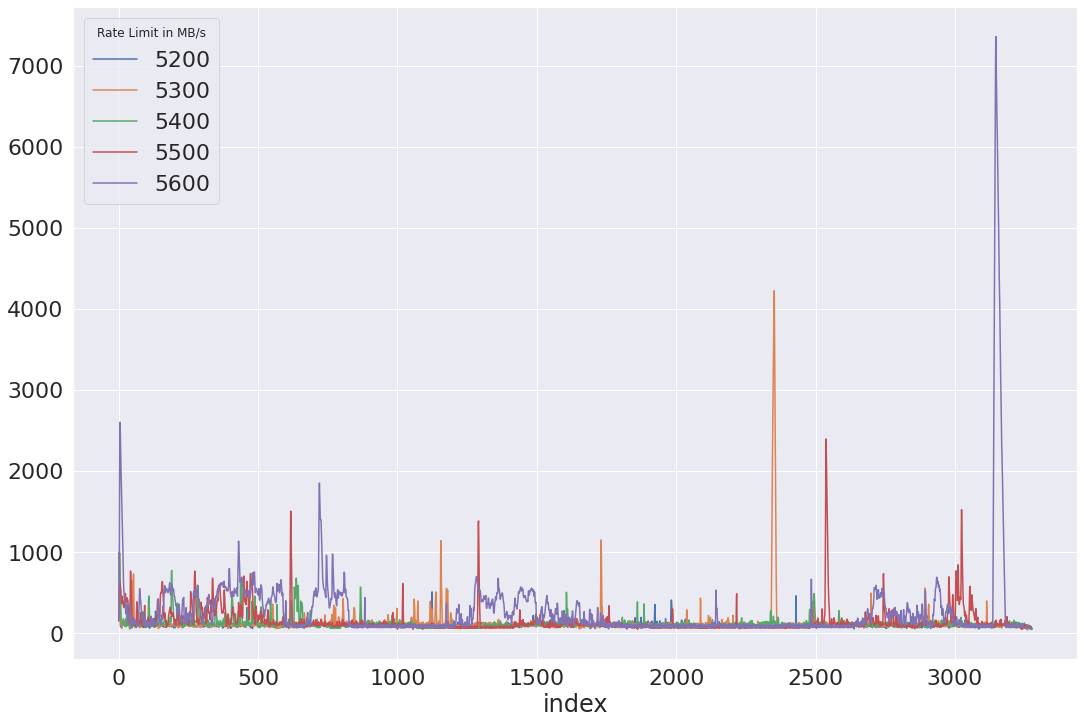

In [80]:
plot_timeseries(filtered, "Avg. Latency in us")

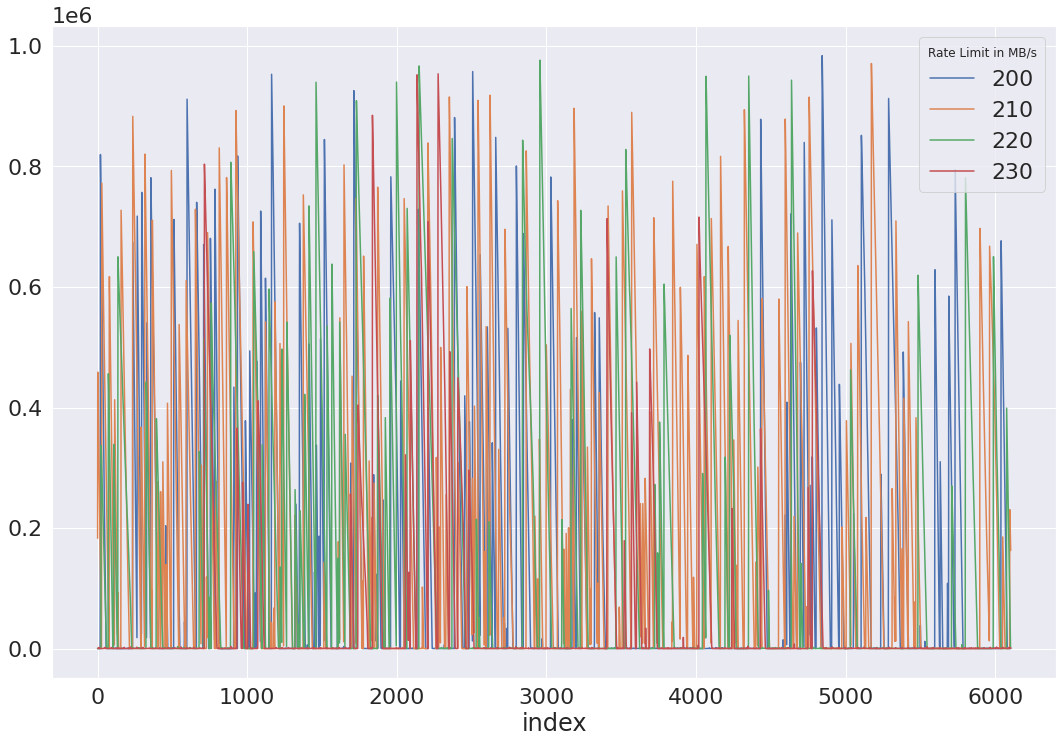

In [103]:
plot_timeseries(kafka_timeline_df[kafka_timeline_df["Rate Limit in MB/s"] < 240], "Avg. Latency in us")

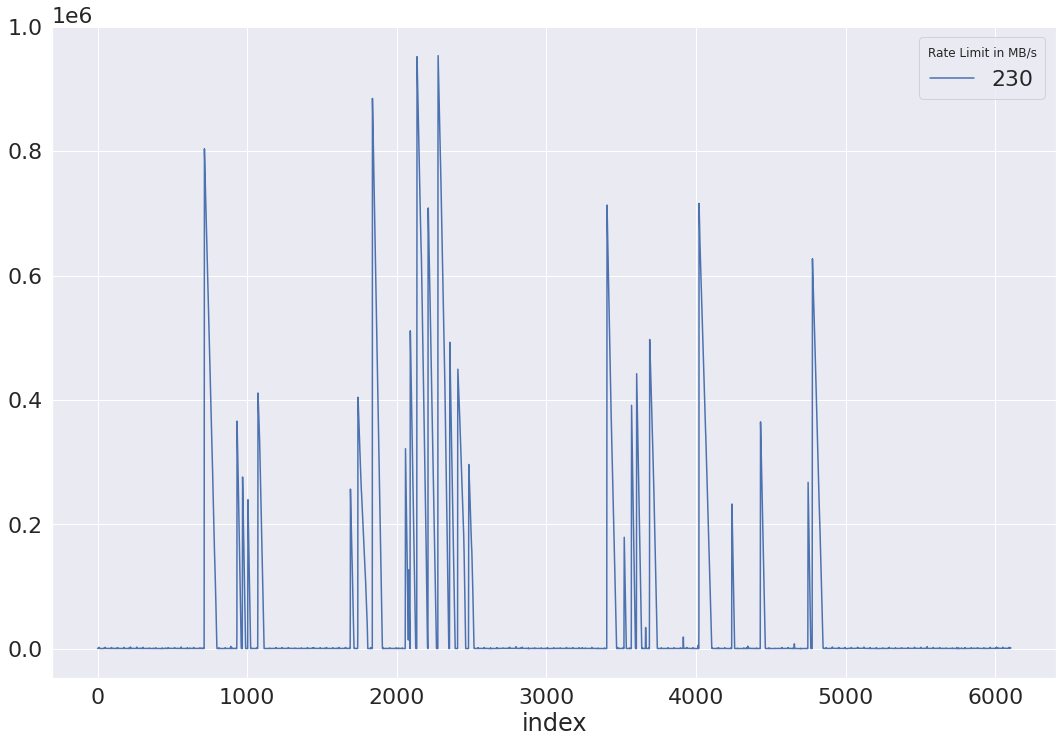

In [109]:
plot_timeseries(kafka_timeline_df[kafka_timeline_df["Rate Limit in MB/s"] == 230], "Avg. Latency in us")

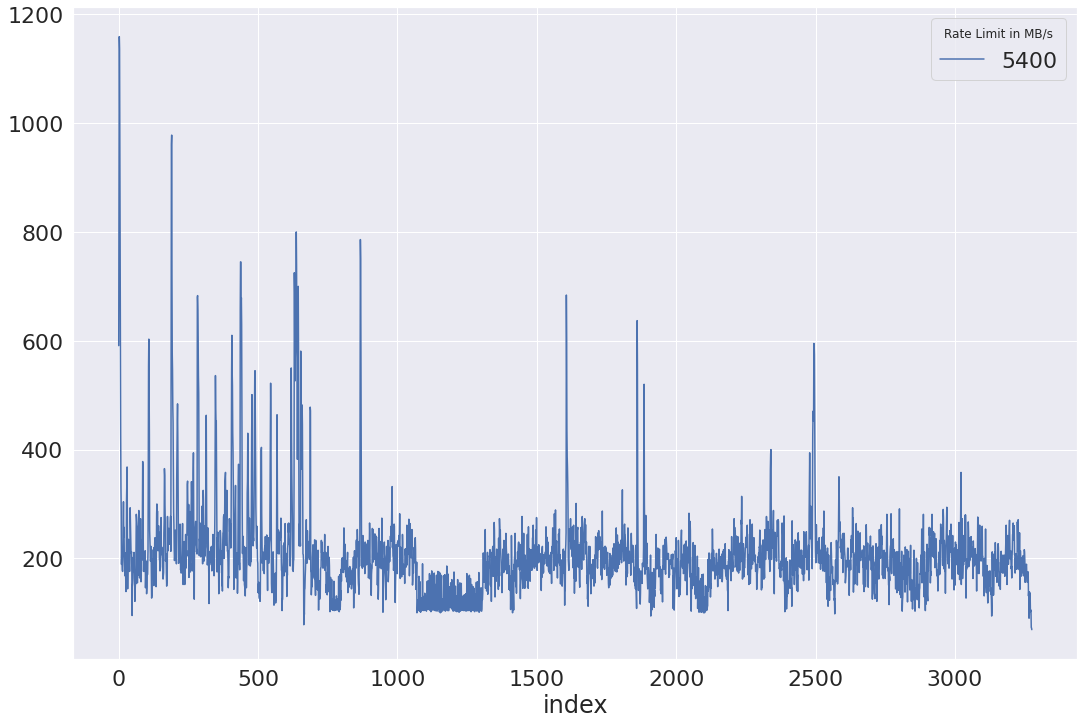

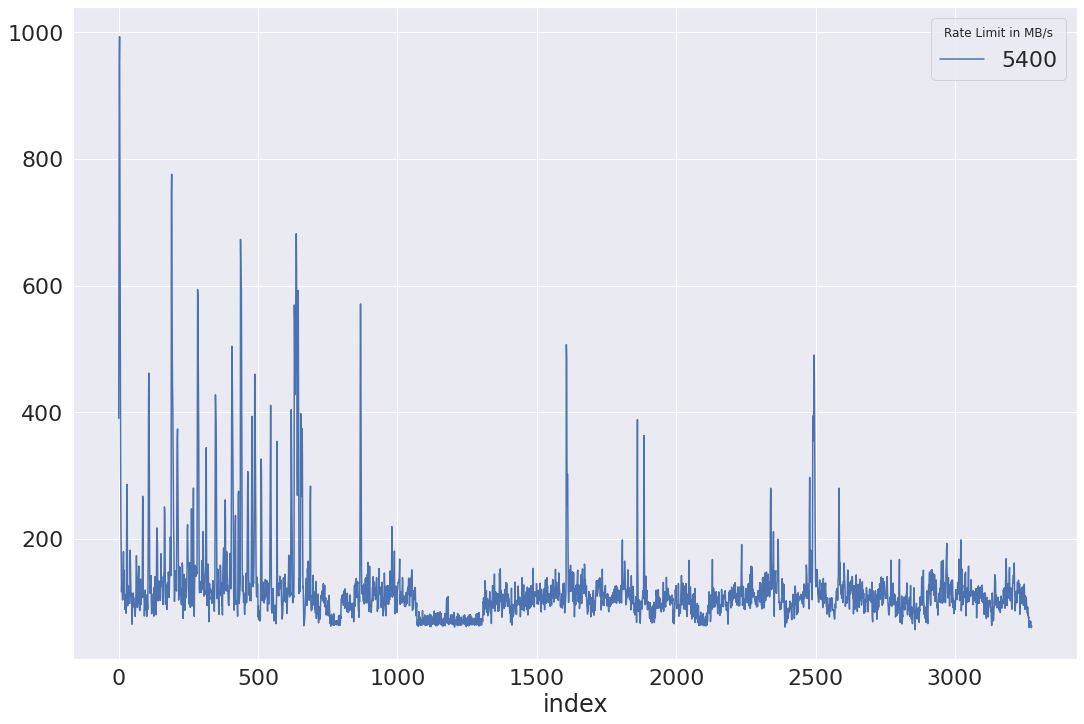

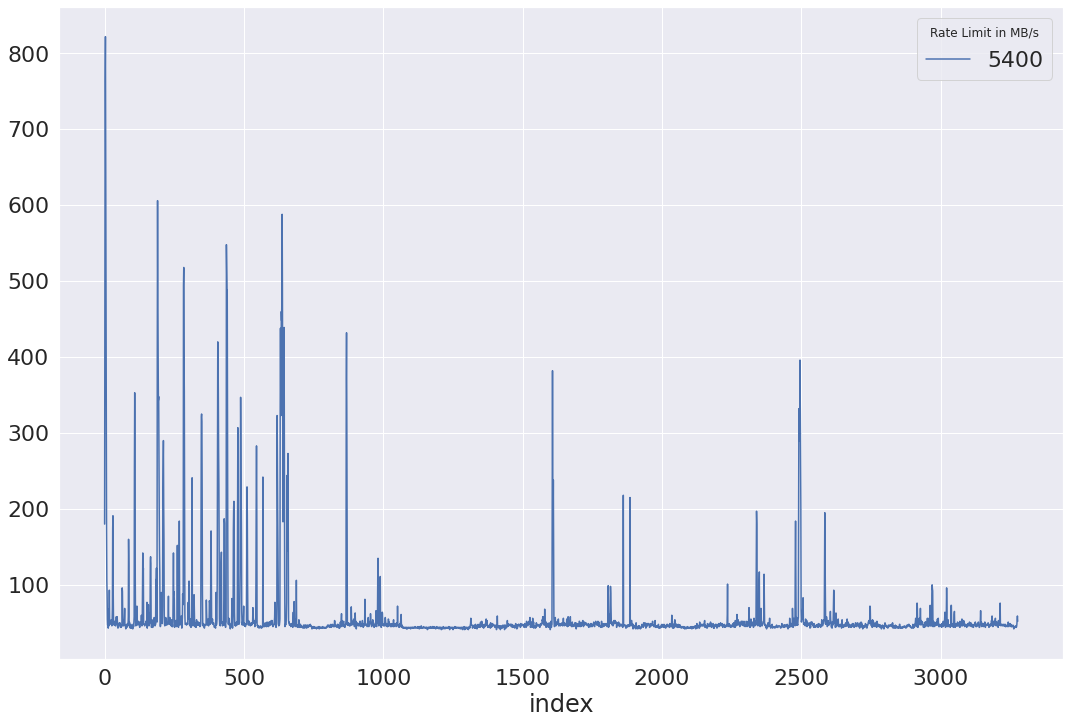

In [91]:
plot_timeseries(filtered[filtered["Rate Limit in MB/s"] == 5400], "Max. Latency in us")
plot_timeseries(filtered[filtered["Rate Limit in MB/s"] == 5400], "Avg. Latency in us")
plot_timeseries(filtered[filtered["Rate Limit in MB/s"] == 5400], "Min. Latency in us")

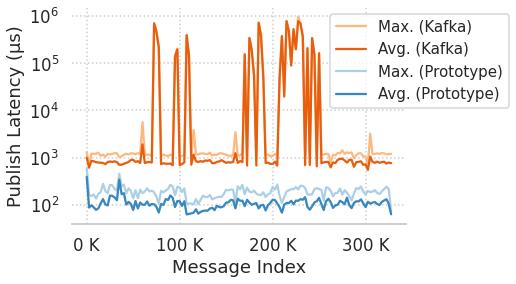

In [222]:
rembrandt_ts = filtered[filtered["Rate Limit in MB/s"] == 5400]
kafka_ts = kafka_timeline_df[kafka_timeline_df["Rate Limit in MB/s"] == 230]
rembrandt_ts.reset_index(inplace=True)
kafka_ts.reset_index(inplace=True)
kafka_ts = kafka_ts.iloc[:rembrandt_ts.shape[0]]
rembrandt_ts = rembrandt_ts.iloc[::25, :]
kafka_ts = kafka_ts.iloc[::25, :]
rembrandt_ts["index"] = rembrandt_ts["index"] * 0.1
kafka_ts["index"] = kafka_ts["index"] * 0.1


fig, ax = plt.subplots()
sns.set_context('talk')
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
sns.despine(left=True)
rembrandt_ts.rename(columns={"Max. Latency in us": "Max. (Prototype)", "Avg. Latency in us": "Avg. (Prototype)", "Min. Latency in us": "Min. (Prototype)"}, inplace=True)
rembrandt_ts = rembrandt_ts.melt(id_vars="index", value_vars=["Max. (Prototype)", "Avg. (Prototype)"])
kafka_ts.rename(columns={"Max. Latency in us": "Max. (Kafka)", "Avg. Latency in us": "Avg. (Kafka)", "Min. Latency in us": "Min. (Kafka)"}, inplace=True)
kafka_ts = kafka_ts.melt(id_vars="index", value_vars=["Max. (Kafka)", "Avg. (Kafka)"])
# g = sns.lineplot(x="index", y="Max. Latency in us", data=kafka_ts, ax=ax)
# g = sns.lineplot(x="index", y="Avg. Latency in us", data=kafka_ts, ax=ax)
# g = sns.lineplot(x="index", y="Min. Latency in us", data=kafka_ts, ax=ax)
g = sns.lineplot(x="index", y="value", hue="variable", data=kafka_ts, ax=ax, palette="Oranges")
g = sns.lineplot(x="index", y="value", hue="variable", data=rembrandt_ts, ax=ax, palette="Blues")
# g = sns.lineplot(x="index", y="Max. Latency in us", data=rembrandt_ts, ax=ax)
# g = sns.lineplot(x="index", y="Avg. Latency in us", data=rembrandt_ts, ax=ax)
# g = sns.lineplot(x="index", y="Min. Latency in us", data=rembrandt_ts, ax=ax)
xlabels = ['{:,.0f}'.format(x) + ' K' for x in g.get_xticks()]
g.set_xticklabels(xlabels)
# g.set_xlabel("Message Size")
g.set_ylabel("Publish Latency (μs)")
g.set_xlabel("Message Index")
ax.set_yscale('log')
# g.set_xticks([8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608])
# g.set_xticklabels(['8K','16K','32K','64K','128K','256K','512K','1M', '2M', '4M', '8M'])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:3] + handles[4:], labels=labels[1:3] + labels[4:], ncol=1, bbox_to_anchor=(0.75, 0.5), fontsize="small")
# plt.xticks(rotation=45)
#     plt.yticks(fontsize=20)
fig.savefig("latencies", bbox_inches="tight", dpi=600)